imports
-----------

In [1]:
#standard library imports
import copy
import pylab
from sklearn.manifold import TSNE
import h5py
import scipy
import datetime
import math
import cmasher as cmr
from matplotlib.lines import Line2D
from matplotlib_venn import venn3
from scipy import linalg as LA
import glob
import yaml
from scipy.stats import linregress
import pandas as pd
from collections import Counter
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
np.random.seed(123456)
import pickle
import seaborn as sns
from scipy.spatial.distance import squareform
import warnings
from statistics import median
warnings.filterwarnings("ignore", category=DeprecationWarning) 
from os.path import join, dirname, abspath
import os
import shutil
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, LeaveOneOut, RepeatedStratifiedKFold, KFold
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from tqdm.auto import tqdm
from matplotlib.gridspec import GridSpec
from scipy import stats

%matplotlib inline

In [2]:
from moseq2_viz.model.util import (relabel_by_usage, parse_model_results, compute_syllable_explained_variance)
from moseq2_app.gui.progress import update_progress, restore_progress_vars
from moseq2_viz.util import parse_index
from moseq2_viz.scalars.util import scalars_to_dataframe
from moseq2_viz.model.util import compute_behavioral_statistics
from moseq2_viz.util import read_yaml


Functions
----------

UMAP preprocessing and functions
--------------------

In [3]:
# upload data
warnings.simplefilter('ignore')
#mean_df = pd.read_csv('/n/groups/datta/Dana/Estrous/mean_df_female_oldnew_1120.csv')
#scalar_df = pd.read_csv('/n/groups/datta/Dana/Estrous/scalar_df.csv')
#mean_df = mean_df[mean_df.rep!=1] # loose first dat
#mean_df = mean_df[mean_df['group'].str.contains('NA') ==False]

In [8]:
# upload data
warnings.simplefilter('ignore')
mean_df = pd.read_csv('/n/groups/datta/Dana/Estrous/script_paper/mean_df_female_control.csv')
male_mean_df=mean_df.copy()

In [10]:
mean_df

,Unnamed: 0,Unnamed: 0.1,uuid,syllable,usage,duration,angle,area_mm,area_px,centroid_x_mm,...,width_px,dist_to_center_px,timestamps,frame index,syllable key,SubjectName,group,mouse,cage,rep
0,0,0,2696aa7a-2db1-478a-8b06-0f04a5bed53a,0,0.042697,0.230409,2.025791,804.71450,495.55710,-226.23561,...,16.123947,172.60724,6.222297e+08,19583.265228,labels (usage sort),01_01_10,default,01_01,1,10
1,1,1,84378a02-0d7c-4e5b-a3c1-3a3acc58bc7c,0,0.038782,0.230218,5.319938,807.82220,497.47092,-236.16880,...,16.426718,171.48488,4.826820e+07,15889.271989,labels (usage sort),01_01_11,default,01_01,1,11
2,2,2,0883ad1a-dfab-4e4e-8927-55692697f18f,0,0.040221,0.248624,5.281333,780.64435,480.73430,-224.51271,...,15.962548,167.10019,1.402057e+08,17934.685117,labels (usage sort),01_01_12,default,01_01,1,12
3,3,3,46fe84ff-b4a7-4695-97a7-a7491f1d05b0,0,0.031472,0.225000,0.948212,794.83990,489.47620,-230.41507,...,16.347200,172.27937,2.269346e+08,20462.656085,labels (usage sort),01_01_13,default,01_01,1,13
4,4,4,4bc700e8-8089-4b8b-a89f-0d3216bca818,0,0.044294,0.268644,0.191095,794.21010,489.08832,-227.04912,...,16.488457,162.76593,3.127252e+08,19543.649842,labels (usage sort),01_01_14,default,01_01,1,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5385,6489,6874,5e5944f9-2386-4b4b-b2cc-472bdb65421e,48,0.010326,0.328205,5.646509,633.57306,387.83594,-245.67815,...,15.735066,183.07070,1.457728e+08,21563.414062,labels (usage sort),04_04_12,default,04_04,4,12
5386,6490,6875,127231d3-36dc-40db-9e5f-42c636581f93,48,0.005708,0.377778,1.288023,637.93475,390.50590,-237.39397,...,15.766957,188.36890,3.186408e+08,23655.358824,labels (usage sort),04_04_14,default,04_04,4,14
5387,6491,6876,13833274-77b5-4705-9b21-09301bcc77c7,48,0.010114,0.333333,4.613818,657.55566,402.51666,-266.65787,...,16.159056,193.92531,4.011614e+08,23488.579167,labels (usage sort),04_04_15,default,04_04,4,15
5388,6492,6877,1c42ee93-ed5b-4955-9d61-9388fe9324a6,48,0.008860,0.488406,9.321574,659.20325,403.52520,-250.34099,...,16.371010,193.69174,4.874523e+08,26437.747774,labels (usage sort),04_04_16,default,04_04,4,16


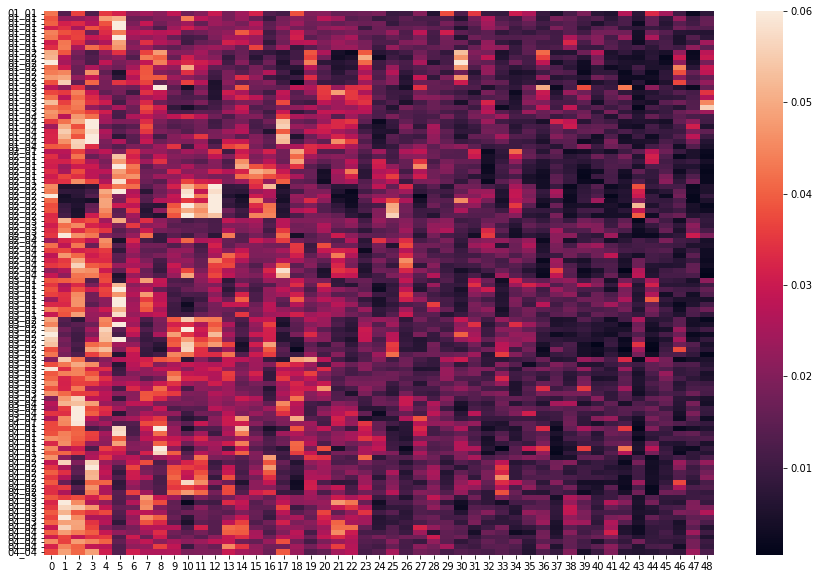

In [9]:
# show syllable loads
# prepare data
data = male_mean_df.groupby(by = ['mouse', 'rep','syllable']).mean()['usage'].reset_index()
data = pd.pivot_table(data, values='usage', index=['mouse', 'rep'], columns=['syllable']).reset_index().fillna(0)
data_umap = data.drop(['mouse','rep'], axis=1).to_numpy()
data_umap_labels = data['mouse'].to_numpy()


fig, ax = plt.subplots()
fig.set_size_inches(15,10) 
sns.heatmap(data_umap,vmax=0.06,yticklabels=data_umap_labels)